In [1]:
# default_exp analyses

In [2]:
#| code-summary: -- load dependencies and data and select parameters
#| output: asis

from compmemlearn.analyses import recall_by_all_study_positions

analysis_overview = """
# Semantic PFR
The probability of starting free recall with an item as a function of its similarity to the initial item(s) in a study sequence.
"""

analysis_tag = 'sempfr'
embedding_paths = ['../../data/cdcatmr-cat.npy', '../../data/cdcatmr-cat.npy', '../../data/cdcatmr-cat.npy']

data_paths = ["../../reports/subjectwise_model_evaluation/results/lightcatCDCATBEH_Semantic_CMR_ll27_sim_df.csv",
"../../data/CDCATBEH.csv", "../../reports/subjectwise_model_evaluation/results/lightcatCDCATBEH_Context_Semantic_CMR_ll27_sim_df.csv",]
trial_queries = [
    ["list_type == 'light'"], 
     ["list_type == 'light'"], 
     ["list_type == 'light'"], 
    ]
query_labels = trial_queries

show_figure = True
regenerate_figure = True
section_tags = ["CDCATBEH", "SemanticCMR", "ContextSemanticCMR"]
figures_path = "figures/"
figure_caption = """Rate of first recall by serial position measured as a function of list length using data from @{}."""

print(analysis_overview)


# Semantic PFR
The probability of starting free recall with an item as a function of its similarity to the initial item(s) in a study sequence.



In [3]:
# export
#| code-summary: --specify semantic probability of first recall analysis code


from compmemlearn.datasets import events_metadata, generate_trial_mask
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
from sentence_transformers import util
from numba import njit

@njit(nogil=True)
def fast_sem_pfr(item_index_by_trial, item_index_by_presentation, distances, edges, buffer=2):
    
    first_recalls = item_index_by_trial[:, 0]
    first_presentations = item_index_by_presentation[:, :1+buffer]
    last_presentations = item_index_by_presentation[:, -1-buffer:]
    total_actual_distances = np.zeros(len(edges))
    
    # For each item recalled first in a trial that is outside an initial presentation buffer, 
    # compute its similarity to the initially studied item in each trial.
    for i in range(buffer, len(first_recalls)):
        if first_recalls[i] < 0:
            continue
        if np.sum(first_recalls[i] == first_presentations[i]) > 0:
            continue
        if np.sum(first_recalls[i] == last_presentations[i]) > 0:
            continue
        distanceA = distances[first_recalls[i], first_presentations[i, 0]]
        distanceB = distances[first_recalls[i], last_presentations[i, 0]]
        distance_bin = np.sum(edges < (distanceA + distanceB)/2 , dtype=np.int32)
        total_actual_distances[distance_bin] += 1

    return total_actual_distances / np.sum(total_actual_distances)

In [4]:
# export
#| code-summary: -- specify semantic contiguity effect plotting code

def plot_sem_pfr(data, trial_query, string_embeddings, contrast_name=None, labels=None, axis=None):

    if axis is None:
        plt.figure()
        axis = plt.gca()

    if labels is None:
        labels = [''] * len(data)

    result = []
    for data_index, events in enumerate(data):

        # generate and subset trials array and list of list_lengths based on trial_query
        trials, list_lengths, _, item_index_by_pres, item_index_by_trial = events_metadata(events)[:6]
        trial_mask = generate_trial_mask(events, trial_query)
        chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
        assert(len(chose) == 1)
        chose = chose[0]
        trials = trials[chose]
        list_length = list_lengths[chose]
        item_index_by_trial = item_index_by_trial[chose]
        item_index_by_pres = item_index_by_pres[chose]
        trial_mask = trial_mask[chose]

        # set edges based on distances between unique item_index_by_trial in current dataset
        if data_index == 0:
            distances = 1-util.pytorch_cos_sim(string_embeddings, string_embeddings).numpy()
            distances[np.eye(len(distances), dtype=int)] = np.nan
            edges = np.nanpercentile(distances, np.linspace(1, 100, 10))

        for subject in pd.unique(events.subject):
            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f"subject == {subject}")[chose], trial_mask
            )

            if np.sum(subject_specific_trial_mask) == 0:
                continue

            res = fast_sem_pfr(item_index_by_trial, item_index_by_pres, distances, edges)
            result.append(pd.DataFrame.from_dict(
                {
                    "subject": subject,
                    "bin": edges,
                    "prob": res,
                    contrast_name: labels[data_index],
                }
            ))

    result = pd.concat(result).reset_index()
    sns.lineplot(ax=axis, data=result, x='bin', y='prob', err_style='bars', hue=contrast_name, legend=False)
    axis.set(xlabel='Semantic Distance', ylabel='Probability of First Recall')

    if contrast_name:
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return axis, result


[0.  0.3 0.6 0.9 1.2]


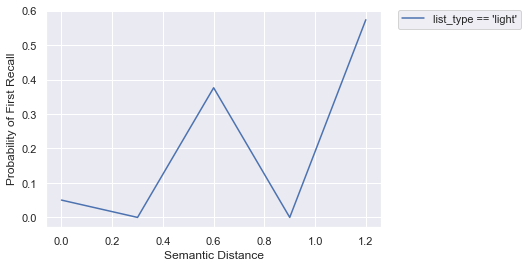

[0.  0.3 0.6 0.9 1.2]


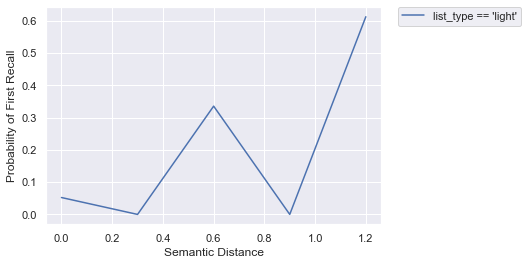

[0.  0.3 0.6 0.9 1.2]


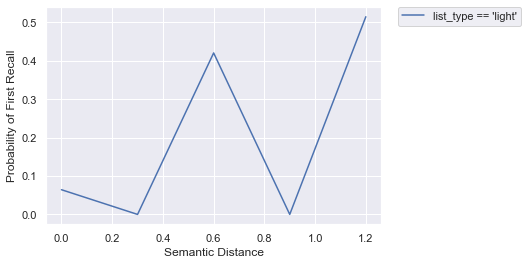

In [5]:
#| code-summary: -- perform and visualize pfr using pre-defined parameters
#| output: asis

import os.path

sns.set(style='darkgrid')

for i in range(len(data_paths)):
    section_tag = section_tags[i]
    trial_query = trial_queries[i]
    query_label = query_labels[i]
    data_path = data_paths[i]
    embedding_path = embedding_paths[i]
    embedding_name = embedding_path[embedding_path.rfind('/')+1:embedding_path.rfind('.')]

    if regenerate_figure or show_figure:
        ax = None
        for query in trial_query:

            events = pd.read_csv(data_path)
            ax = plot_sem_pfr([events], query, np.load(embedding_path), labels=[query], axis=ax)[0]

        ax.legend(query_label, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        if regenerate_figure:
            plt.savefig(
                figures_path+f'{section_tag}_{analysis_tag}_{embedding_name}.pdf', 
                bbox_inches="tight")
                
        if show_figure:
            plt.show()
        else:
            print(
                f"""::: {{#fig-{section_tag}_{analysis_tag} layout-valign="center"}}
                
![]({section_tag}_{analysis_tag}_{embedding_name}.pdf)

{figure_caption}
:::""");
        plt.close()

    else:
        if not os.path.isfile(f'{section_tag}_{analysis_tag}_{embedding_name}.pdf'):
            print(
                f'Figure not found at {figures_path}{section_tag}_{analysis_tag}.pdf. Run with regenerate_figure=True to generate.')
        else:
            print(
                f"""::: {{#fig-{section_tag}_{analysis_tag} layout-valign="center"}}
                
![]({figures_path}{section_tag}_{analysis_tag}.pdf)

{figure_caption}
:::""");